## ***GNNExplainer***


> Moduled: Accpeting the four GNNs (GCN+GAP, DGCNN, DIFFPOOL, and GIN)


---

In [ ]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-z250qthv
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-z250qthv
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit 38bb5f29375e9ba9dc56654af8d3f35551480f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
from statistics import mean
import torch_geometric
from torch_geometric.datasets import TUDataset
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn
from torch.autograd import graph
from typing import Any, Dict, Optional, Union
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [ ]:
Explainability_name = 'GNNExplainer'
Task_name = 'Graph Classification'
Model_Name = "GCN_plus_GAP"
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"
DataSet_name = "MUTAG"

File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [ ]:
#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#print("Number of Training Graphs: ", len(train_dataset))
#print("Number of Test Graphs: ", len(test_dataset))

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [ ]:
BATCH_SIZE = 64


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
print(train_dataloader.batch_size)
batch = next(iter(train_dataloader))
print(batch.y)
print(len(train_dataloader))

64
tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])
3


In [ ]:
from torch_geometric.datasets import FakeDataset

num_graphs = 100
avg_num_nodes = 20
avg_degree = 15
node_feat_dim = 13
edge_feat_dim = 0
num_classes = 3

dataset = FakeDataset(num_graphs=num_graphs, avg_num_nodes=avg_num_nodes, avg_degree=avg_degree, num_channels=node_feat_dim,
                      edge_dim=edge_feat_dim, num_classes=num_classes,)

In [ ]:
print(len(dataset[0].x))

22


In [ ]:
BATCH_SIZE = 10

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)

#import GCN_plus_GAP as Graph_Network
#GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=13, hidden_dim=13, output_dim=3,
#                                       num_hid_layers=2, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
#                                       dropout_rate=classifier_dropout)

#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 11], num_classes=3, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5,
#                                    Weight_Initializer=3, Bias=False, dgcnn_k=17, node_feat_size=13, hid_channels=[16,32], conv1d_kernels=[2,5],
#                                    ffn_layer_size=128, strides=[2,1])

#import DIFFPOOL as diffpool_model
#GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=13, embedding_num_block_layers=1, embedding_hid_dim=64,
#                                          new_feature_size=64, assignment_input_dim=13, assignment_num_block_layers=1,
#                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
#                                          concat_neighborhood=False, num_classes=3, Weight_Initializer=1, Bias=classifier_bias,
#                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
#                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")

import GIN as gin_model
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=13, mlp_hid_dim=13,
                                mlp_output_dim=2, mlp_act_fun="ReLu", dropout_rate=classifier_dropout,
                                Weight_Initializer=1, joint_embeddings=False)

In [ ]:
print(GNN_Model)

GIN_Model(
  (gin_mlp_layers): ModuleList(
    (0-3): 4 x GIN_MLPs(
      (gin_mlp_layers): ModuleList(
        (0-1): 2 x Linear(in_features=13, out_features=13, bias=True)
      )
      (gin_batch_normalization): ModuleList(
        (0-1): 2 x BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (global_summing): GlobalSUMPool()
  (lin1): Linear(in_features=65, out_features=65, bias=True)
  (lin2): Linear(in_features=65, out_features=3, bias=True)
  (dorpout): Dropout(p=0.1, inplace=False)
)


In [ ]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [ ]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

In [ ]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:
        if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
            batch_loss = loss_calculations(soft, batch_of_graphs.y)
            Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
            Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, prediction_output = GNN_Model(batch_of_graphs, None)
            Pred_Labels.extend(prediction_output.argmax(dim=1).detach().tolist())
            batch_loss = loss_calculations(prediction_output, batch_of_graphs.y)

        elif GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
            batch_loss = loss_calculations(lin2_output_softmaxed, batch_of_graphs.y)
            Pred_Labels.extend(lin2_output_softmaxed.argmax(dim=1).detach().tolist())
        else:
            raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [ ]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
        #  torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 1.1624
Epoch: 002, Model Loss: 1.1276
Epoch: 003, Model Loss: 1.1626
Epoch: 004, Model Loss: 1.0738
Epoch: 005, Model Loss: 1.1173
Epoch: 006, Model Loss: 1.1456
Epoch: 007, Model Loss: 1.1810
Epoch: 008, Model Loss: 1.1449
Epoch: 009, Model Loss: 1.1371
Epoch: 010, Model Loss: 1.1340
Epoch: 011, Model Loss: 1.1636
Epoch: 012, Model Loss: 1.1554
Epoch: 013, Model Loss: 1.1249
Epoch: 014, Model Loss: 1.1454
Epoch: 015, Model Loss: 1.1545
Epoch: 016, Model Loss: 1.1523
Epoch: 017, Model Loss: 1.1139
Epoch: 018, Model Loss: 1.1420
Epoch: 019, Model Loss: 1.1392
Epoch: 020, Model Loss: 1.1717
Epoch: 021, Model Loss: 1.1414
Epoch: 022, Model Loss: 1.1501
Epoch: 023, Model Loss: 1.1519
Epoch: 024, Model Loss: 1.1309
Epoch: 025, Model Loss: 1.1819
Epoch: 026, Model Loss: 1.1657
Epoch: 027, Model Loss: 1.0790
Epoch: 028, Model Loss: 1.1587
Epoch: 029, Model Loss: 1.1580
Epoch: 030, Model Loss: 1.1474
Epoch: 031, Model Loss: 1.1398
Epoch: 032, Model Loss: 1.1355
Epoch: 0

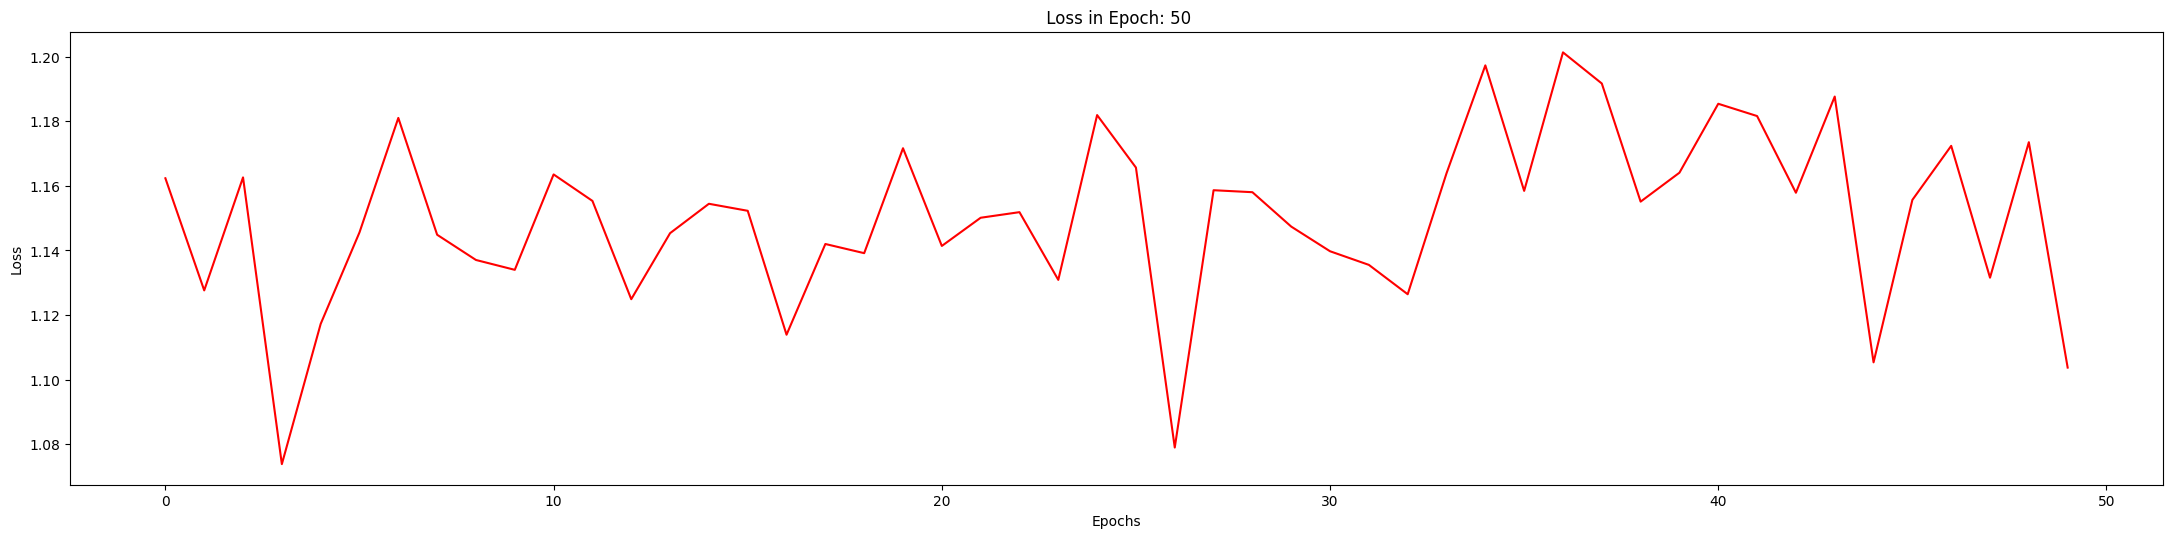

Epoch: 051, Model Loss: 1.1713
Epoch: 052, Model Loss: 1.1580
Epoch: 053, Model Loss: 1.1720
Epoch: 054, Model Loss: 1.2094
Epoch: 055, Model Loss: 1.1583
Epoch: 056, Model Loss: 1.1320
Epoch: 057, Model Loss: 1.1018
Epoch: 058, Model Loss: 1.1618
Epoch: 059, Model Loss: 1.1849
Epoch: 060, Model Loss: 1.1923
Epoch: 061, Model Loss: 1.1116
Epoch: 062, Model Loss: 1.1722
Epoch: 063, Model Loss: 1.2243
Epoch: 064, Model Loss: 1.2348
Epoch: 065, Model Loss: 1.1481
Epoch: 066, Model Loss: 1.1877
Epoch: 067, Model Loss: 1.1735
Epoch: 068, Model Loss: 1.1441
Epoch: 069, Model Loss: 1.1757
Epoch: 070, Model Loss: 1.1348
Epoch: 071, Model Loss: 1.1604
Epoch: 072, Model Loss: 1.1827
Epoch: 073, Model Loss: 1.1659
Epoch: 074, Model Loss: 1.1463
Epoch: 075, Model Loss: 1.1517
Epoch: 076, Model Loss: 1.1419
Epoch: 077, Model Loss: 1.1513
Epoch: 078, Model Loss: 1.1530
Epoch: 079, Model Loss: 1.1558
Epoch: 080, Model Loss: 1.1316
Epoch: 081, Model Loss: 1.1514
Epoch: 082, Model Loss: 1.1514
Epoch: 0

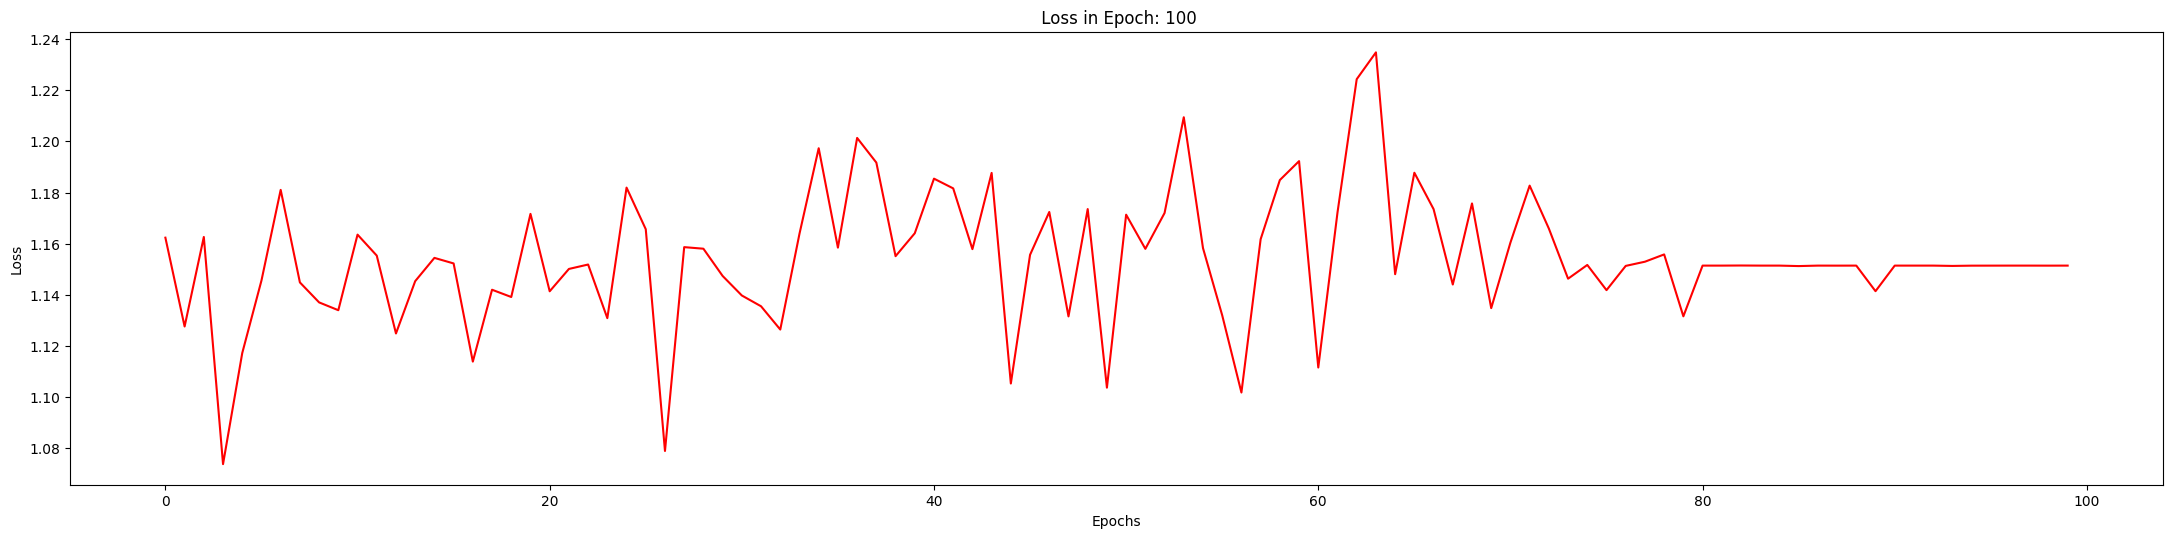

Epoch: 101, Model Loss: 1.1514
Epoch: 102, Model Loss: 1.1514
Epoch: 103, Model Loss: 1.1514
Epoch: 104, Model Loss: 1.1515
Epoch: 105, Model Loss: 1.1614
Epoch: 106, Model Loss: 1.1514
Epoch: 107, Model Loss: 1.1514
Epoch: 108, Model Loss: 1.1514
Epoch: 109, Model Loss: 1.1515
Epoch: 110, Model Loss: 1.1514
Epoch: 111, Model Loss: 1.1514
Epoch: 112, Model Loss: 1.1514
Epoch: 113, Model Loss: 1.1514
Epoch: 114, Model Loss: 1.1514
Epoch: 115, Model Loss: 1.1514
Epoch: 116, Model Loss: 1.1514
Epoch: 117, Model Loss: 1.1514
Epoch: 118, Model Loss: 1.1582
Epoch: 119, Model Loss: 1.1514
Epoch: 120, Model Loss: 1.1414
Epoch: 121, Model Loss: 1.1514
Epoch: 122, Model Loss: 1.1514
Epoch: 123, Model Loss: 1.1514
Epoch: 124, Model Loss: 1.1415
Epoch: 125, Model Loss: 1.1598
Epoch: 126, Model Loss: 1.1514
Epoch: 127, Model Loss: 1.1514
Epoch: 128, Model Loss: 1.1514
Epoch: 129, Model Loss: 1.1514
Epoch: 130, Model Loss: 1.1514
Epoch: 131, Model Loss: 1.1514
Epoch: 132, Model Loss: 1.1514
Epoch: 1

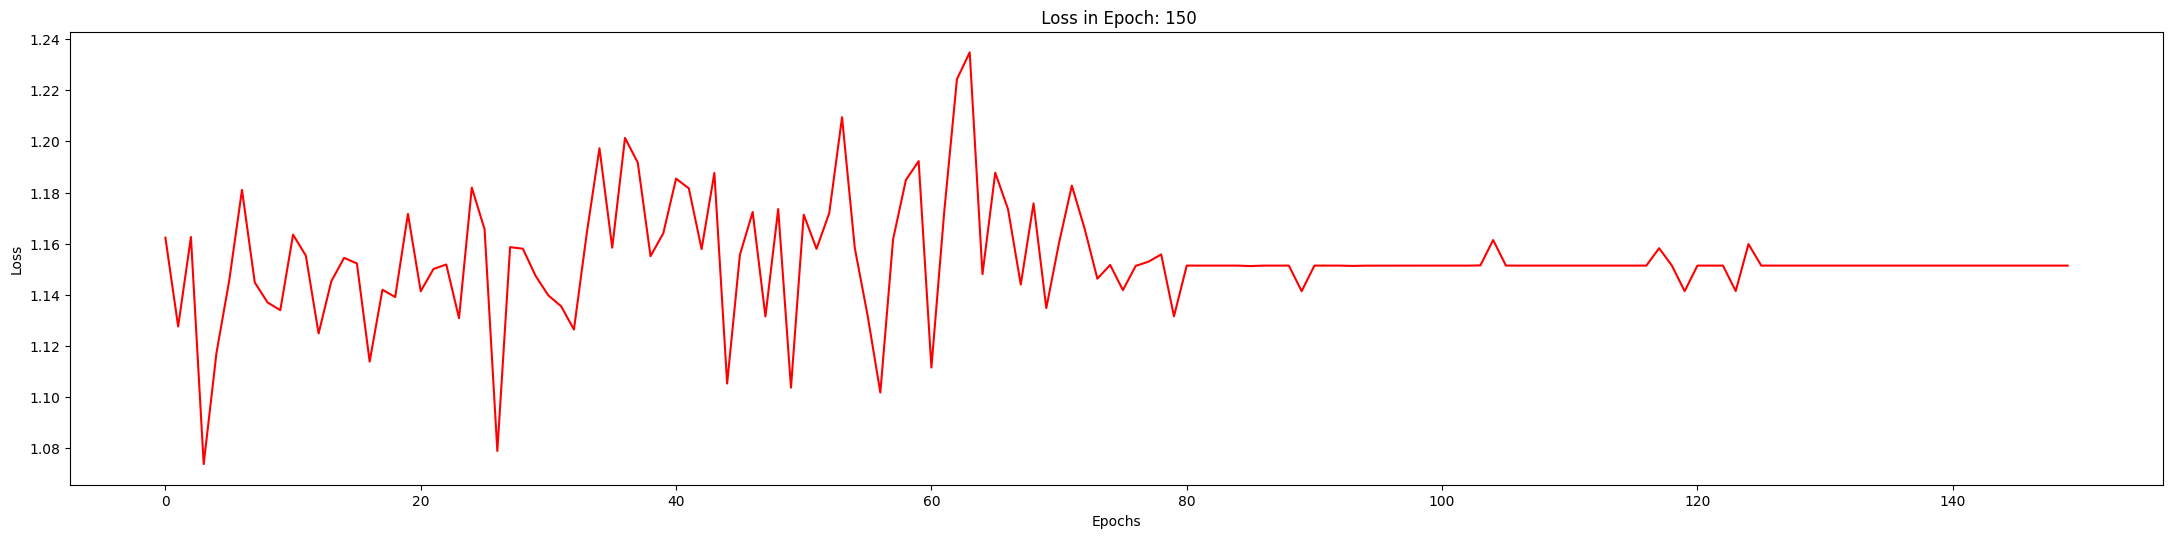

Epoch: 151, Model Loss: 1.1514
Epoch: 152, Model Loss: 1.1511
Epoch: 153, Model Loss: 1.1514
Epoch: 154, Model Loss: 1.1514
Epoch: 155, Model Loss: 1.1514
Epoch: 156, Model Loss: 1.1514
Epoch: 157, Model Loss: 1.1542
Epoch: 158, Model Loss: 1.1514
Epoch: 159, Model Loss: 1.1514
Epoch: 160, Model Loss: 1.1514
Epoch: 161, Model Loss: 1.1514
Epoch: 162, Model Loss: 1.1514
Epoch: 163, Model Loss: 1.1514
Epoch: 164, Model Loss: 1.1514
Epoch: 165, Model Loss: 1.1514
Epoch: 166, Model Loss: 1.1514
Epoch: 167, Model Loss: 1.1510
Epoch: 168, Model Loss: 1.1514
Epoch: 169, Model Loss: 1.1514
Epoch: 170, Model Loss: 1.1514
Epoch: 171, Model Loss: 1.1514
Epoch: 172, Model Loss: 1.1514
Epoch: 173, Model Loss: 1.1514
Epoch: 174, Model Loss: 1.1514
Epoch: 175, Model Loss: 1.1514
Epoch: 176, Model Loss: 1.1514
Epoch: 177, Model Loss: 1.1515
Epoch: 178, Model Loss: 1.1526
Epoch: 179, Model Loss: 1.1514
Epoch: 180, Model Loss: 1.1514
Epoch: 181, Model Loss: 1.1514
Epoch: 182, Model Loss: 1.1514
Epoch: 1

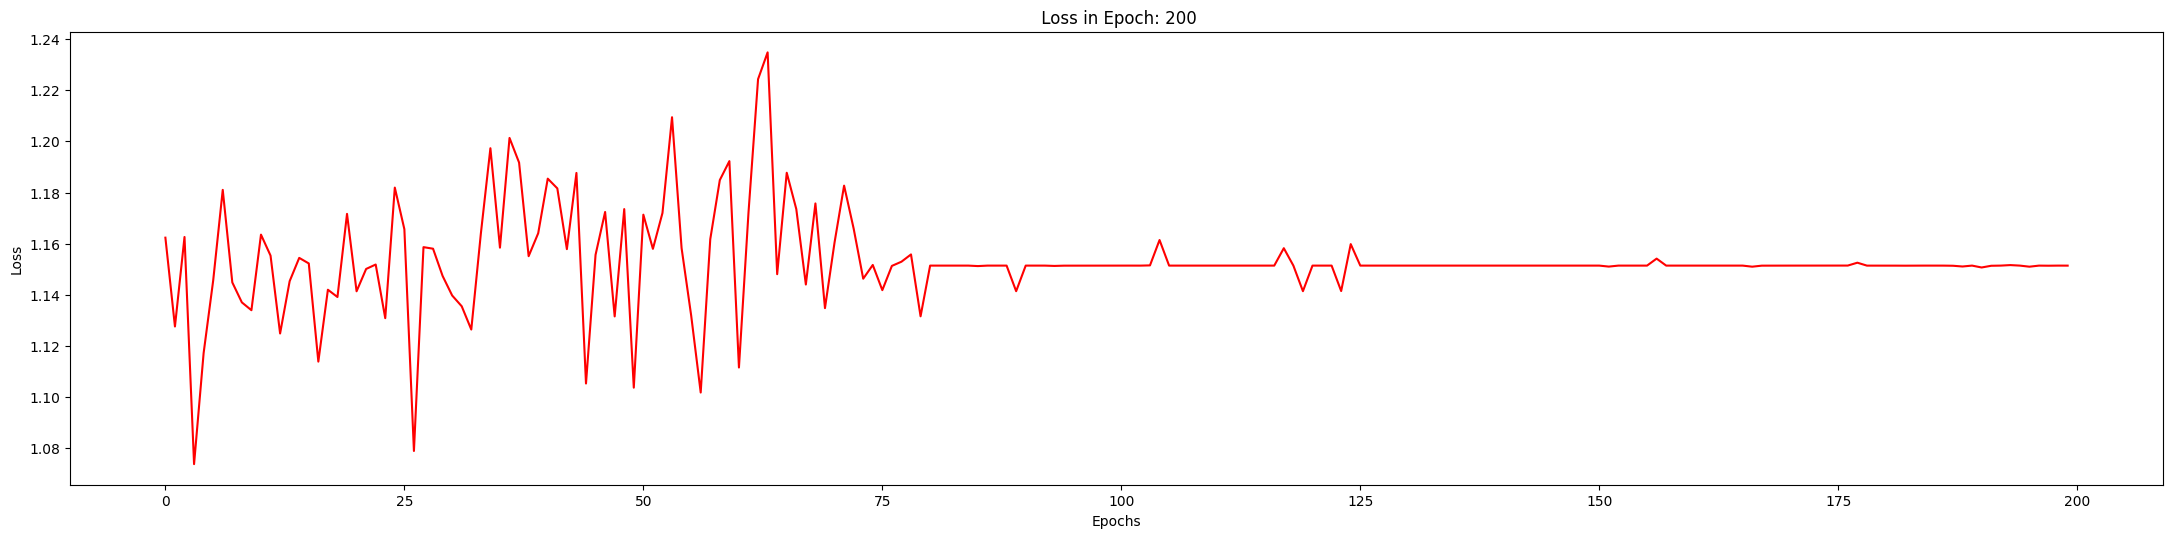

Epoch: 201, Model Loss: 1.1514
Epoch: 202, Model Loss: 1.1569
Epoch: 203, Model Loss: 1.1514
Epoch: 204, Model Loss: 1.1514
Epoch: 205, Model Loss: 1.1513
Epoch: 206, Model Loss: 1.1514
Epoch: 207, Model Loss: 1.1515
Epoch: 208, Model Loss: 1.1515
Epoch: 209, Model Loss: 1.1514
Epoch: 210, Model Loss: 1.1514
Epoch: 211, Model Loss: 1.1515
Epoch: 212, Model Loss: 1.1514
Epoch: 213, Model Loss: 1.1514
Epoch: 214, Model Loss: 1.1514
Epoch: 215, Model Loss: 1.1513
Epoch: 216, Model Loss: 1.1514
Epoch: 217, Model Loss: 1.1514
Epoch: 218, Model Loss: 1.1513
Epoch: 219, Model Loss: 1.1461
Epoch: 220, Model Loss: 1.1518
Epoch: 221, Model Loss: 1.1613
Epoch: 222, Model Loss: 1.1415
Epoch: 223, Model Loss: 1.1499
Epoch: 224, Model Loss: 1.1514
Epoch: 225, Model Loss: 1.1434
Epoch: 226, Model Loss: 1.1446
Epoch: 227, Model Loss: 1.1476
Epoch: 228, Model Loss: 1.1404
Epoch: 229, Model Loss: 1.1541
Epoch: 230, Model Loss: 1.1514
Epoch: 231, Model Loss: 1.1514
Epoch: 232, Model Loss: 1.1513
Epoch: 2

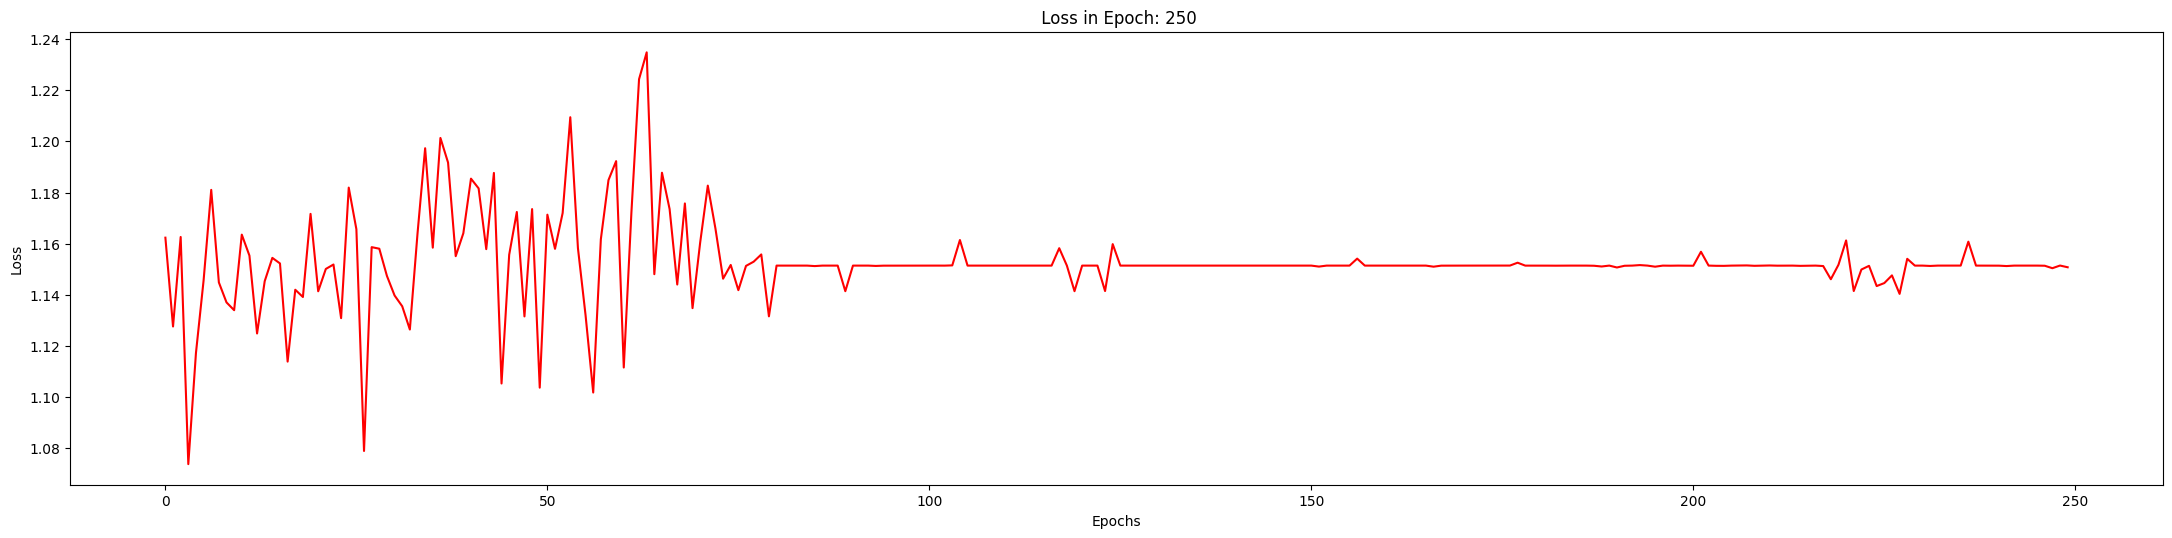

Epoch: 251, Model Loss: 1.1455
Epoch: 252, Model Loss: 1.1514
Epoch: 253, Model Loss: 1.1513
Epoch: 254, Model Loss: 1.1514
Epoch: 255, Model Loss: 1.1514
Epoch: 256, Model Loss: 1.1514
Epoch: 257, Model Loss: 1.1514
Epoch: 258, Model Loss: 1.1514
Epoch: 259, Model Loss: 1.1529
Epoch: 260, Model Loss: 1.1514
Epoch: 261, Model Loss: 1.1514
Epoch: 262, Model Loss: 1.1514
Epoch: 263, Model Loss: 1.1502
Epoch: 264, Model Loss: 1.1514
Epoch: 265, Model Loss: 1.1514
Epoch: 266, Model Loss: 1.1532
Epoch: 267, Model Loss: 1.1514
Epoch: 268, Model Loss: 1.1514
Epoch: 269, Model Loss: 1.1514
Epoch: 270, Model Loss: 1.1514
Epoch: 271, Model Loss: 1.1514
Epoch: 272, Model Loss: 1.1514
Epoch: 273, Model Loss: 1.1514
Epoch: 274, Model Loss: 1.1514
Epoch: 275, Model Loss: 1.1514
Epoch: 276, Model Loss: 1.1514
Epoch: 277, Model Loss: 1.1484
Epoch: 278, Model Loss: 1.1514
Epoch: 279, Model Loss: 1.1514
Epoch: 280, Model Loss: 1.1514
Epoch: 281, Model Loss: 1.1525
Epoch: 282, Model Loss: 1.1526
Epoch: 2

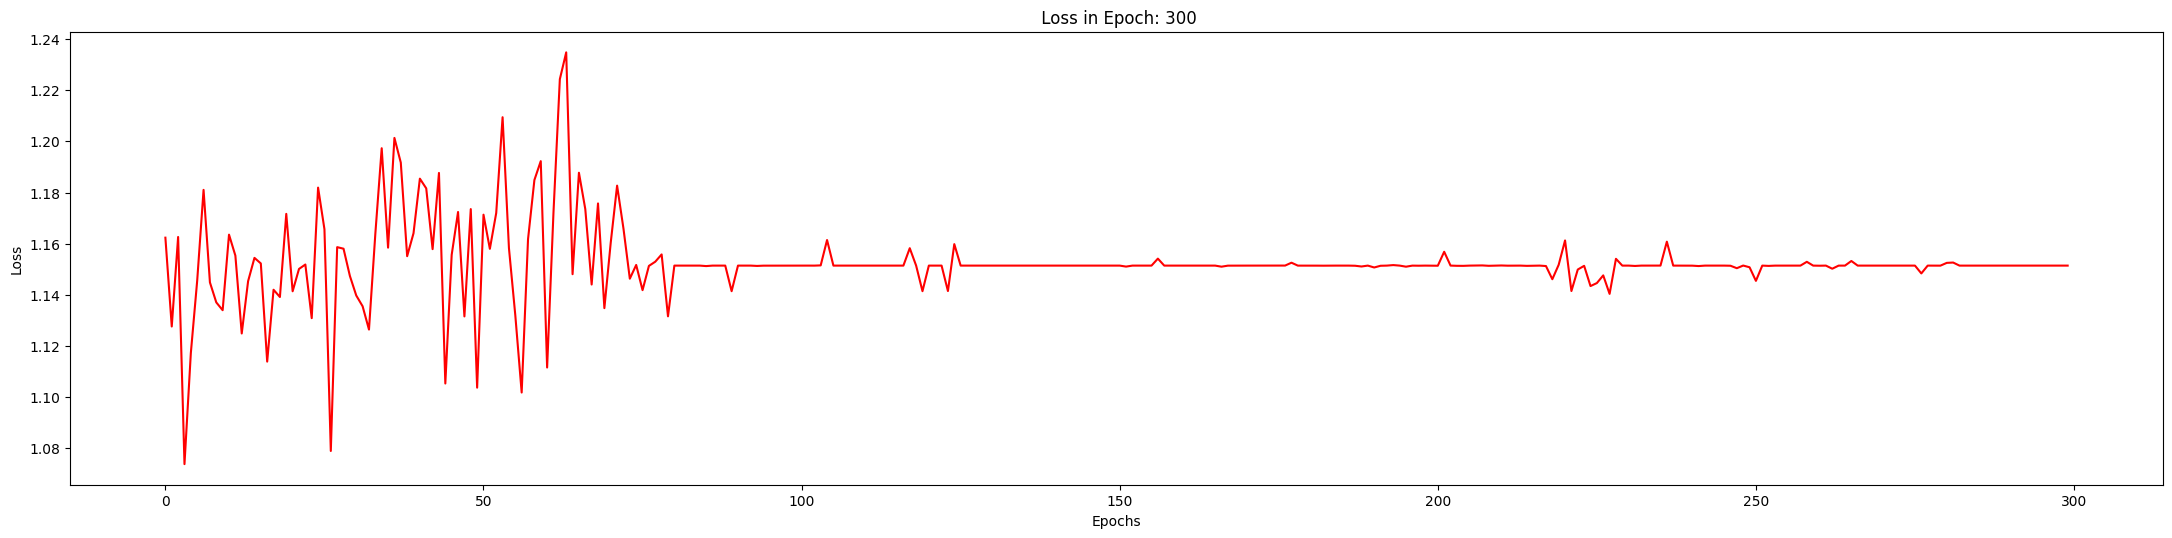

In [ ]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index)

In [ ]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
from statistics import mean
import torch_geometric
from torch_geometric.datasets import TUDataset
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch_geometric.nn as gnn
from torch.autograd import graph
from typing import Any, Dict, Optional, Union
from IPython.core.display import deepcopy
from torch_geometric.nn import MessagePassing
import copy
loss_fn = F.binary_cross_entropy_with_logits


class GNNExplainer:
    coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
        'EPS': 1e-15,
        }
    def __init__(self, GNN_Model, Exp_Epoch, Exp_lr):

        self.GNN_Model = GNN_Model
        self.loss_fn = F.binary_cross_entropy_with_logits

        self.explainer_epochs = Exp_Epoch
        self.explainer_lr = Exp_lr
        self.node_mask = self.edge_mask = None
        self.softmax = nn.Softmax(dim=-1)

        if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            pass
        elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
            pass
        elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            pass
        elif self.GNN_Model.__class__.__name__ == "GIN_Model":
            pass
        else:
            raise Exception("We cover GCN_plus_GAP, DGCNN, DIFFPOOL, and GIN.")


    def initialize_masks(self, graph_to_explain):
        (N, F), E = (1, len(graph_to_explain.x[0])), len(graph_to_explain.edge_index[1])
        std = 0.1
        self.node_mask = Parameter(torch.randn(N, F) * std, requires_grad=True)
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = Parameter(torch.randn(E) * std, requires_grad=True)

        if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            for module in self.GNN_Model.modules():
                if isinstance(module, MessagePassing):
                    module.__explain__ = True
                    module.__edge_mask__ = self.edge_mask
                    module._apply_sigmoid = True

    def explainer_loss(self, By_Perturbation_predicted_label, predicted_label):
        By_Perturbation_predicted_label = By_Perturbation_predicted_label.to(torch.float32)
        predicted_label = predicted_label.to(torch.float32)

        loss_in_explainer_stage = self.loss_fn(By_Perturbation_predicted_label, predicted_label)

        m = self.edge_mask.sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])                                             ######.         MARGINALIZE Over All Feature Subsets
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['edge_size'] * edge_reduce(m)
        ent = -m * torch.log(m + self.coeffs['EPS']) - (1 - m) * torch.log(1 - m + self.coeffs['EPS'])
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_mask.sigmoid()                                                                            ######.         Element-wise Entropy for structural and node feature masks to be discrete
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + self.coeffs['EPS']) - (1 - m) * torch.log(1 - m + self.coeffs['EPS'])
        loss_in_explainer_stage = loss_in_explainer_stage + self.coeffs['node_feat_ent'] * ent.mean()

        return loss_in_explainer_stage

    def explainer_train_step(self, graph_to_explain, predicted_label):
        new_graph_by_masks = graph_to_explain

        parameters = [self.node_mask]
        parameters.append(self.edge_mask)

        explainer_optimizer = torch.optim.Adam(parameters, lr=self.explainer_lr)
        for i in range(self.explainer_epochs):
            explainer_optimizer.zero_grad()

            h_node = graph_to_explain.x * self.node_mask.sigmoid()
            new_graph_by_masks.x = h_node

            if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
                Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = self.GNN_Model(new_graph_by_masks)
            elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
                final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = self.GNN_Model(new_graph_by_masks, self.edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
                concatination_list_of_poolings, soft = self.GNN_Model(new_graph_by_masks, self.edge_mask.tolist())
            elif self.GNN_Model.__class__.__name__ == "GIN_Model":
                mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = self.GNN_Model(new_graph_by_masks, self.edge_mask.tolist())


            By_Perturbation_predicted_label = soft.argmax(dim=-1)

            loss = self.explainer_loss(By_Perturbation_predicted_label, predicted_label)

            loss.backward()
            explainer_optimizer.step()

    def post_process_mask(self, mask, apply_soft):
        if apply_soft:
            mask = mask.detach()
            mask = self.softmax(mask)
            return mask
        else:
            return mask

    def node_post_process_mask(self, node_mask, graph):
        attributed_graph = []
        attributed_graph_normalized = []
        attributed_graph_standardized = []
        for node in graph.x:
            attributed_graph.append(sum(np.multiply(node.tolist(), node_mask.tolist()[0])))

        for score in attributed_graph:
            attributed_graph_normalized.append(abs(((score-min(attributed_graph))*100/(max(attributed_graph)-min(attributed_graph)))).tolist())

        for score in attributed_graph_normalized:
            attributed_graph_standardized.append(abs(score / max(attributed_graph_normalized)))

        return attributed_graph_standardized


    def train_explainer(self, main_graph_to_explain, graph_to_explain, class_index):

        self.GNN_Model.eval()
        if self.GNN_Model.__class__.__name__ == "GCN_plus_GAP":
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = self.GNN_Model(graph_to_explain)
        elif self.GNN_Model.__class__.__name__ == "DGCNN_Model":
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, soft = self.GNN_Model(graph_to_explain, None)
        elif self.GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
            concatination_list_of_poolings, soft = self.GNN_Model(graph_to_explain, None)
        elif self.GNN_Model.__class__.__name__ == "GIN_Model":
            mlps_output_embeds, mlp_outputs_globalSUMpooled, lin1_output, lin1_output_dropouted, lin2_output, soft = self.GNN_Model(graph_to_explain, None)

        predicted_label = soft.detach()[:,class_index]

        self.initialize_masks(graph_to_explain)
        self.explainer_train_step(graph_to_explain, predicted_label)

        node_mask = self.node_post_process_mask(self.node_mask, main_graph_to_explain)
        edge_mask = self.post_process_mask(self.edge_mask, True)
        return node_mask, edge_mask


    def __call__(self, graph_to_explain, class_index):
        new_graph_by_masks = deepcopy(graph_to_explain.detach())
        node_mask, edge_mask = self.train_explainer(graph_to_explain, new_graph_by_masks, class_index)

        return node_mask, edge_mask


times = []
explanations_nodes = []
class_index = 2
for graph in train_dataloader:
    t1 = perf_counter()
    EXP = GNNExplainer(GNN_Model, 300, 0.001)
    correct_node_mask, correct_edge_mask = EXP(graph, class_index)
    times.append(perf_counter()-t1)
    explanations_nodes.append(correct_node_mask)
    print("class: ", class_index, " node_masks: ", correct_node_mask)


class:  2  node_masks:  [0.5429632510111553, 0.4828194621003952, 0.5389739720473004, 0.5112758976595757, 0.41762942720562735, 0.5919292766268817, 0.6868729984249833, 0.3651442170831272, 0.5905275408088592, 0.4394961167350071, 0.4966119576381843, 0.4936517523300048, 0.4464877295768493, 0.4006947116691827, 0.3610298108312941, 0.5572771823144764, 0.7295165455190876, 0.8223260966380133, 0.747235384097382, 0.8892221072628983, 0.7664682758978255, 0.8403056181958241, 0.7016572292408967, 0.957834004703879, 0.6872929381607717, 0.8154276905700641, 0.9007189738128306, 0.9009719011652528, 0.8890716202919551, 0.9289589274034812, 0.8556618969082834, 0.9157057753816074, 0.7792584432171767, 0.9304523525161414, 0.6735414584912989, 0.871672497188361, 0.6824645472334616, 0.8414215937179716, 0.5679457879606539, 0.429556336496014, 0.3878941285397673, 0.4087570947501897, 0.48875272549458076, 0.5197837895645672, 0.5368109731205076, 0.5940123669546038, 0.5216816626769346, 0.6010477926818937, 0.428002769195690

In [ ]:
#predicted_label = soft.detach()[:,class_index]

In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/GNNExplainer on Graph Classification/Script/'
sys.path.insert(0,py_path)
import gnnexplainer_on_graph_classification as gnnExplainer

In [ ]:
times = []
explanations_nodes = []
class_index = 2
for graph in dataset:
    t1 = perf_counter()
    EXP = gnnExplainer.GNNExplainer(GNN_Model, 300, 0.001)
    node_mask, edge_mask = EXP(graph, class_index)
    times.append(perf_counter()-t1)
    explanations_nodes.append(node_mask)
    print("class: ", class_index, " node_masks: ", node_mask)

class:  2  node_masks:  [0.361095781851864, 0.6807503540459335, 0.0, 0.23168017130663654, 0.570083588574862, 0.47858055174173125, 0.5033473920914803, 0.08619538350281587, 0.21425125564600742, 0.42968493324302465, 0.79070371022448, 0.3621490654598143, 0.49279028239987993, 0.6990012260604782, 0.9181883077021677, 0.3622418699274807, 0.7654033483745665, 0.23561372354569834, 1.0, 0.8609841472113736, 0.5764619425726731, 0.8505326180272501]
class:  2  node_masks:  [0.7457810668375134, 0.6343919813599272, 0.4455556272959036, 0.5354413703341522, 0.27787882429415506, 0.14470574962023164, 1.0, 0.841492183303849, 0.2580355905683756, 0.2947973757326298, 0.5818207313436254, 0.2889178921375505, 0.24563206343134894, 0.0, 0.6828007579901737, 0.3609515460487057, 0.1629452441448546, 0.424775492783372, 0.793263668901332, 0.24753344634142554, 0.06997400506322099, 0.8550326607206548, 0.4231390192629016]
class:  2  node_masks:  [0.2563192219360777, 0.47719980812799745, 0.0, 0.09735264698250021, 0.26118302378